In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/niclasmettenleiter/projects/TennisRacketSwingweightPrediction


In [2]:
# pip install torch matplotlib seaborn

In [3]:

import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression, BayesianRidge

from sklearn.linear_model import ElasticNetCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern
from sklearn import tree
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from xgboost import XGBRegressor

from src.tennisracketswingweightprediction.evaluation import evaluate_multiple_models

from src.tennisracketswingweightprediction.modules.gan_trainer import GANTrainer
from src.tennisracketswingweightprediction.modules.torch_preprocessing import (
    TabularDataProcessor,
)



In [4]:
data = pd.read_csv("data/racquet_data.csv")

In [5]:
data.head()

,pcode,mfg,racquet,headsize,length,weight,balance,swingweight,flex,acor,...,hittingweight,vibration,filter,distance,spin,angle,shotspeed,swingspeed,plow,time
0,VS5,Volkl,V-Sense 5,100,27.0,276,33.5,281,70,0.255,...,114,164,21/2-effort,68.5,1596,3.6,64.5,51.4,37,0.89
1,U100UL,Wilson,Ultra 100UL,100,27.0,270,34.0,283,68,0.260,...,116,164,21/2-effort,68.5,1595,3.6,64.8,51.3,38,0.88
2,BULS1H,Wilson,Burn 100 ULS (2017),100,27.0,281,34.1,288,67,0.273,...,119,158,21/2-effort,68.2,1579,3.4,65.2,51.0,39,0.87
3,YEZLLG,Yonex,Ezone Lite,100,27.0,282,33.3,292,64,0.272,...,119,156,21/2-effort,68.1,1579,3.4,65.2,51.0,39,0.87
4,TPS270,Tecnifibre,T-Flash PS 270,100,27.0,285,34.1,293,69,0.271,...,119,160,21/2-effort,67.8,1570,3.5,64.9,50.7,39,0.87


In [6]:
data = data[data["length"] == 27.0]  # focus on 27 inch rackets

In [7]:
# X = data[['headsize', 'length', 'weight', 'balance',
#        'swingweight', 'flex', 'acor', 'sweet',
#        'twistweight', 'hittingweight', 'vibration', 'distance',
#        'spin', 'angle', 'shotspeed', 'swingspeed', 'plow', 'time']]
X = data[["headsize", "weight", "balance", "flex", "swingweight"]]

In [8]:
data

,pcode,mfg,racquet,headsize,length,weight,balance,swingweight,flex,acor,...,hittingweight,vibration,filter,distance,spin,angle,shotspeed,swingspeed,plow,time
0,VS5,Volkl,V-Sense 5,100,27.0,276,33.5,281,70,0.255,...,114,164,21/2-effort,68.5,1596,3.6,64.5,51.4,37,0.89
1,U100UL,Wilson,Ultra 100UL,100,27.0,270,34.0,283,68,0.260,...,116,164,21/2-effort,68.5,1595,3.6,64.8,51.3,38,0.88
2,BULS1H,Wilson,Burn 100 ULS (2017),100,27.0,281,34.1,288,67,0.273,...,119,158,21/2-effort,68.2,1579,3.4,65.2,51.0,39,0.87
3,YEZLLG,Yonex,Ezone Lite,100,27.0,282,33.3,292,64,0.272,...,119,156,21/2-effort,68.1,1579,3.4,65.2,51.0,39,0.87
4,TPS270,Tecnifibre,T-Flash PS 270,100,27.0,285,34.1,293,69,0.271,...,119,160,21/2-effort,67.8,1570,3.5,64.9,50.7,39,0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,PT95,Prince,Tour 95,95,27.0,345,32.4,337,60,0.323,...,136,131,21/2-effort,65.8,1491,2.9,66.2,48.9,43,0.82
258,HG3RMP,Head,Graphene 360 Radical MP,98,27.0,312,32.4,324,68,0.305,...,130,152,21/2-effort,66.8,1526,3.1,66.0,49.7,42,0.84
260,HGTRMP,Head,Graphene Touch Radical MP,98,27.0,310,33.0,327,65,0.313,...,132,151,21/2-effort,66.6,1519,3.0,66.3,49.6,42,0.84
261,BS0398,Prince,Textreme Beast O3 98,98,27.0,318,32.5,326,69,0.316,...,133,155,21/2-effort,66.7,1519,2.9,66.5,49.6,42,0.83


In [9]:
cols = ["headsize", "weight", "balance", "flex", "swingweight"]

processor = TabularDataProcessor(data, cols, device="cpu")
train_loader, input_dim = processor.process(batch_size=32)
scaler = processor.get_scaler()

In [10]:
trainers = {
    "base": GANTrainer(
        input_length=input_dim,
        use_residual=True,
        device="cpu",
        scaler=scaler,
        g_hidden_dim=512,  # WIDER generator
        d_hidden_dim=128,  # Standard discriminator
        g_num_blocks=5,  # DEEPER generator
        d_num_blocks=5,
        scheduler_patience=30,
        use_logits=True,
        diversity_weight=0.0,  # Turn off simple moments matching in favor of Sinkhorn
        sinkhorn_weight=0.0,  # Enable Sinkhorn
        correlation_weight=0.0,  # Enable Correlation Matching
    ),
    "div_weight": GANTrainer(
        input_length=input_dim,
        use_residual=True,
        device="cpu",
        scaler=scaler,
        g_hidden_dim=512,  # WIDER generator
        d_hidden_dim=128,  # Standard discriminator
        g_num_blocks=5,  # DEEPER generator
        d_num_blocks=5,
        scheduler_patience=30,
        use_logits=True,
        diversity_weight=1.0,  # Turn off simple moments matching in favor of Sinkhorn
        sinkhorn_weight=0.0,  # Enable Sinkhorn
        correlation_weight=0.0,  # Enable Correlation Matching
    ),
    "corr_weight": GANTrainer(
        input_length=input_dim,
        use_residual=True,
        device="cpu",
        scaler=scaler,
        g_hidden_dim=512,  # WIDER generator
        d_hidden_dim=128,  # Standard discriminator
        g_num_blocks=5,  # DEEPER generator
        d_num_blocks=5,
        scheduler_patience=30,
        use_logits=True,
        diversity_weight=0.0,  # Turn off simple moments matching in favor of Sinkhorn
        sinkhorn_weight=0.0,  # Enable Sinkhorn
        correlation_weight=1.0,  # Enable Correlation Matching
    ),
    "div_corr_weight": GANTrainer(
        input_length=input_dim,
        use_residual=True,
        device="cpu",
        scaler=scaler,
        g_hidden_dim=512,  # WIDER generator
        d_hidden_dim=128,  # Standard discriminator
        g_num_blocks=5,  # DEEPER generator
        d_num_blocks=5,
        scheduler_patience=30,
        use_logits=True,
        diversity_weight=0.0,  # Turn off simple moments matching in favor of Sinkhorn
        sinkhorn_weight=0.0,  # Enable Sinkhorn
        correlation_weight=1.0,  # Enable Correlation Matching
    ),
}

metrics_dict = {}
samples_dict = {}
for name, trainer in trainers.items():
    trainer.train_loop(train_loader, epochs=100, g_update_freq=1)

    real_data_sample = data[cols].values

    samples = trainer.get_generated_samples(10 * len(real_data_sample))
    samples_dict[name] = samples
    # 1. Plot comparison
    # trainer.plot_distribution_comparison(real_data_sample, samples, feature_names=cols)
    trainer.plot_losses()
    # 2. Print metrics
    metrics = trainer.evaluate_quality(
        real_data_sample, samples[: len(real_data_sample)]
    )
    metrics_dict[name] = metrics

: 

In [ ]:
pd.DataFrame(metrics_dict).T

,avg_wasserstein_dist,correlation_diff,mean_abs_diff,std_abs_diff
base,8.380713,1.555135,7.651193,6.891362
div_weight,1.246431,0.416469,0.905607,0.506860
corr_weight,3.916065,0.496832,3.782734,0.981412
div_corr_weight,2.962506,0.526193,2.821093,0.270441


In [ ]:
def dict_to_markdown_table(
    results_dict,
    approach_names=None,
    metric_names=None,
    transpose=True,
    lower_is_better=True,
    title="Results",
    caption="",
    output_file=None,
):
    """
    Convert nested dict of results to markdown table.

    Args:
        results_dict: Dict with structure {approach: {metric: value}}
        approach_names: Dict to rename approaches (optional)
        metric_names: Dict to rename metrics (optional)
        transpose: If True, metrics as rows, approaches as columns
        lower_is_better: If True, minimum is highlighted; else maximum
        title: Table title
        caption: Table caption
        output_file: Path to save markdown file (optional)

    Returns:
        Markdown string
    """
    if transpose:
        df = pd.DataFrame(results_dict)
        if metric_names:
            df.index = df.index.map(metric_names)
        if approach_names:
            df.columns = df.columns.map(approach_names)

        # Format row-wise
        df_formatted = df.copy()
        for idx in df_formatted.index:
            values = df_formatted.loc[idx].values.astype(float)
            best_val = values.min() if lower_is_better else values.max()

            formatted = []
            for val in values:
                if val == best_val:
                    formatted.append(f"**{val:.4f}**")
                else:
                    formatted.append(f"{val:.4f}")
            df_formatted.loc[idx] = formatted
    else:
        df = pd.DataFrame(results_dict).T
        df.index.name = "Approach"
        df = df.reset_index()

        if approach_names:
            df["Approach"] = df["Approach"].map(approach_names)
        if metric_names:
            cols = ["Approach"] + [
                metric_names.get(c, c) for c in df.columns if c != "Approach"
            ]
            df.columns = cols

        df_formatted = df.set_index("Approach").copy()
        for col in df_formatted.columns:
            values = df_formatted[col].values.astype(float)
            best_val = values.min() if lower_is_better else values.max()

            formatted = []
            for val in values:
                if val == best_val:
                    formatted.append(f"**{val:.4f}**")
                else:
                    formatted.append(f"{val:.4f}")
            df_formatted[col] = formatted

    # Build output
    output = f"# {title}\n\n"
    if caption:
        output += f"*{caption}*\n\n"

    better_str = "Lower" if lower_is_better else "Higher"
    output += f"*{better_str} values indicate better performance. Bold indicates best result per metric.*\n\n"
    output += df_formatted.to_markdown() + "\n"

    if output_file:
        with open(output_file, "w") as f:
            f.write(output)

    return output


# Usage
approach_names = {
    "base": "Baseline",
    "div_weight": "Diversity Loss",
    "corr_weight": "Correlation Loss",
    "div_corr_weight": "Diversity + Correlation",
}

metric_names = {
    "avg_wasserstein_dist": "Wasserstein Distance",
    "correlation_diff": "Correlation Difference",
    "mean_abs_diff": "Mean Absolute Difference",
    "std_abs_diff": "Std Absolute Difference",
}


markdown = dict_to_markdown_table(
    metrics_dict,
    approach_names=approach_names,
    metric_names=metric_names,
    transpose=False,  # Change to False for approaches as rows
    lower_is_better=True,
    title="GAN Training Results",
    caption="Comparison of different loss configurations on tennis racket dataset (n=210).",
    output_file="gan_results.md",
)

In [ ]:
samples_dict

{'base': array([[ 95.98585 , 333.22073 ,  32.070713,  61.018005, 325.9758  ],
        [ 95.91662 , 333.71472 ,  32.050674,  61.00124 , 326.46564 ],
        [ 95.91529 , 333.6324  ,  32.05347 ,  60.992645, 326.43887 ],
        ...,
        [ 96.02152 , 332.5407  ,  32.07559 ,  61.087692, 325.86142 ],
        [ 96.0258  , 332.7387  ,  32.07738 ,  61.139072, 325.61365 ],
        [ 95.87822 , 333.9762  ,  32.057156,  61.023933, 326.3566  ]],
       shape=(2100, 5), dtype=float32),
 'div_weight': array([[ 98.35252 , 337.43878 ,  32.187344,  67.94881 , 326.00934 ],
        [ 94.86936 , 336.2342  ,  32.50263 ,  62.917717, 324.93216 ],
        [ 96.033775, 327.6025  ,  31.933405,  62.900173, 313.93958 ],
        ...,
        [100.17869 , 299.59427 ,  33.21148 ,  69.79277 , 300.75784 ],
        [100.33917 , 315.10632 ,  31.951311,  56.715458, 325.06207 ],
        [ 94.57964 , 325.44138 ,  32.28261 ,  64.05982 , 317.10574 ]],
       shape=(2100, 5), dtype=float32),
 'corr_weight': array([[ 99.73

In [ ]:
data[["headsize", "weight", "balance", "flex", "swingweight"]].describe()

,headsize,weight,balance,flex,swingweight
count,210.000000,210.000000,210.000000,210.000000,210.000000
mean,99.128571,314.047619,32.951905,65.666667,316.076190
std,2.230206,17.450343,0.809230,3.918223,11.107733
min,93.000000,270.000000,31.200000,54.000000,281.000000
25%,98.000000,301.000000,32.400000,63.000000,309.000000
50%,100.000000,318.000000,33.000000,66.000000,317.500000
75%,100.000000,326.000000,33.500000,69.000000,324.000000
max,107.000000,349.000000,35.600000,75.000000,343.000000


In [ ]:
samples = samples_dict["div_weight"]


samples_df = pd.DataFrame(
    samples, columns=["headsize", "weight", "balance", "flex", "swingweight"]
)

samples_df.describe()

,headsize,weight,balance,flex,swingweight
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,98.948975,315.841461,32.902775,65.143593,313.917511
std,1.860607,16.363262,0.724847,3.654463,10.719761
min,94.109131,279.000793,31.671106,55.825356,284.568878
25%,97.738577,302.793533,32.312346,62.880136,306.426247
50%,99.884186,319.070816,32.897482,65.311192,317.097488
75%,100.209721,330.220047,33.318080,68.086979,322.206322
max,103.234566,341.446259,35.212559,72.369812,334.192780


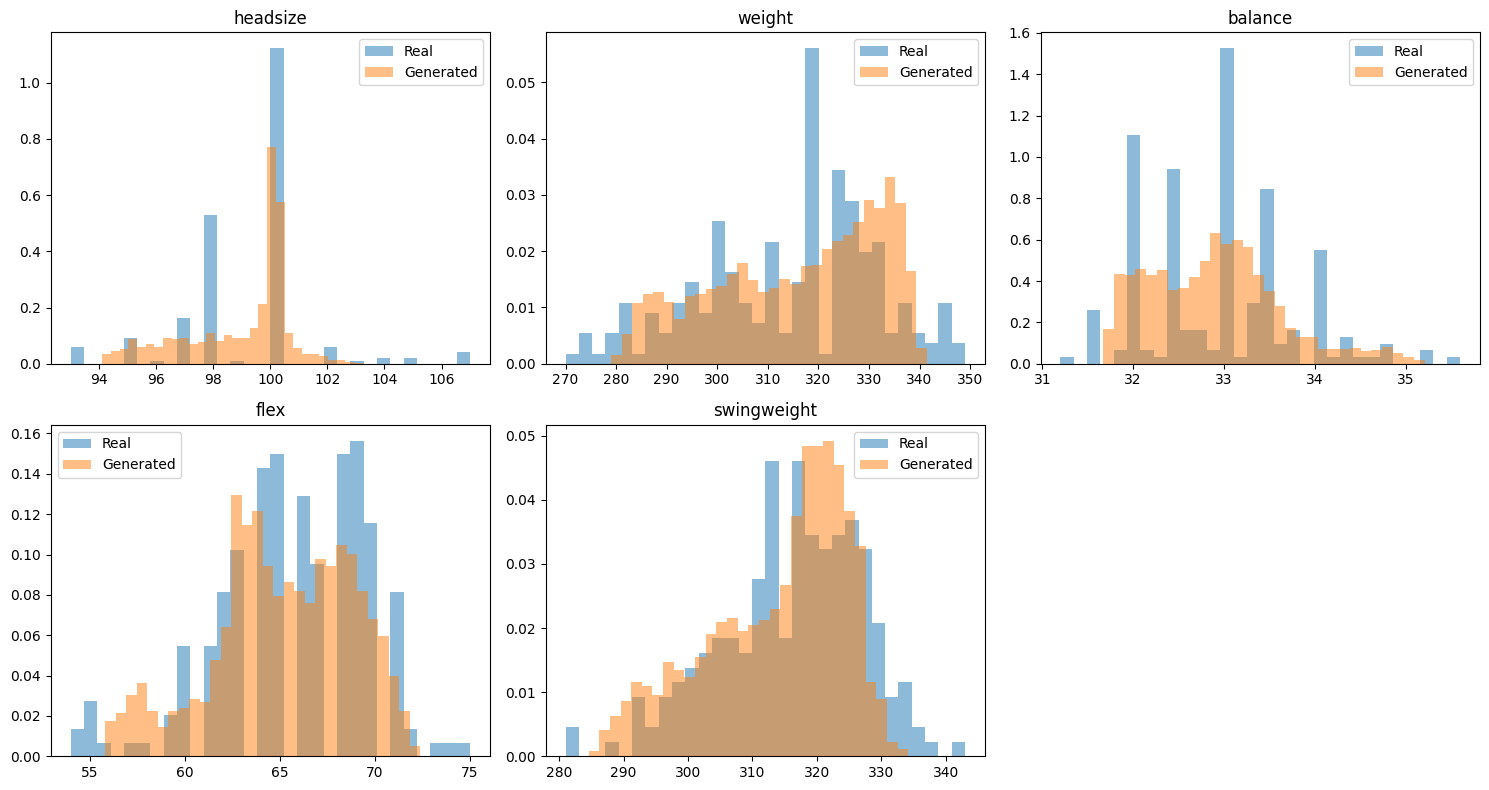


Quality Metrics:
avg_wasserstein_dist: 1.2689
correlation_diff: 0.4851
mean_abs_diff: 0.9408
std_abs_diff: 0.4232


In [ ]:
real_data_sample = data[cols].values


samples_df = pd.DataFrame(samples, columns=cols)
real_data_df = pd.DataFrame(real_data_sample, columns=cols)
samples_df["label"] = "fake"
real_data_df["label"] = "real"

comparison_df = pd.concat([samples_df, real_data_df])
comparison_df

# 1. Plot comparison
trainer.plot_distribution_comparison(real_data_sample, samples, feature_names=cols)

# 2. Print metrics
metrics = trainer.evaluate_quality(real_data_sample, samples)
print("\nQuality Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

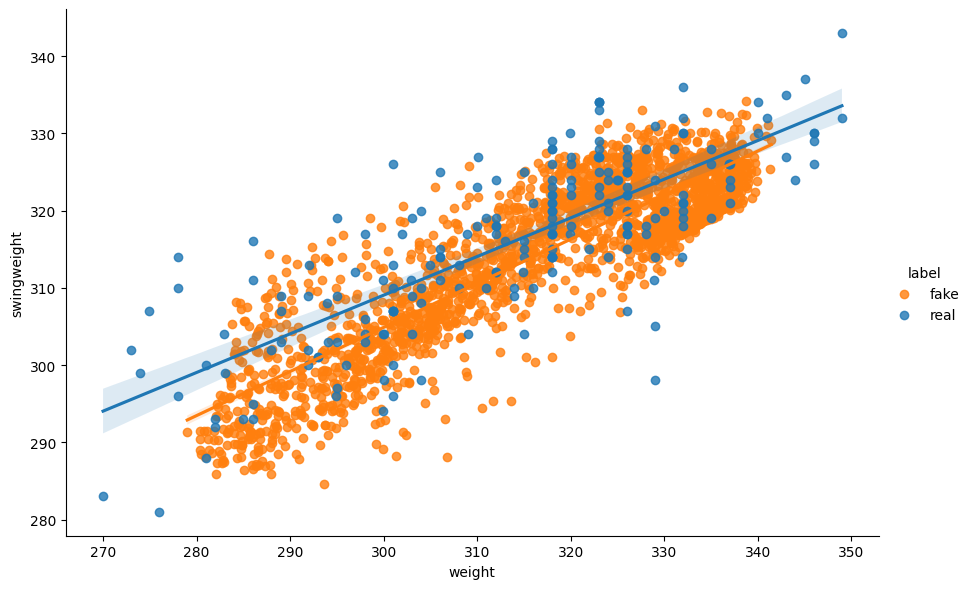

In [ ]:
sns.lmplot(
    x="weight",
    y="swingweight",
    data=comparison_df,
    hue="label",
    x_jitter=0.05,
    palette={"real": "tab:blue", "fake": "tab:orange"},
    height=6,
    aspect=1.5,
)

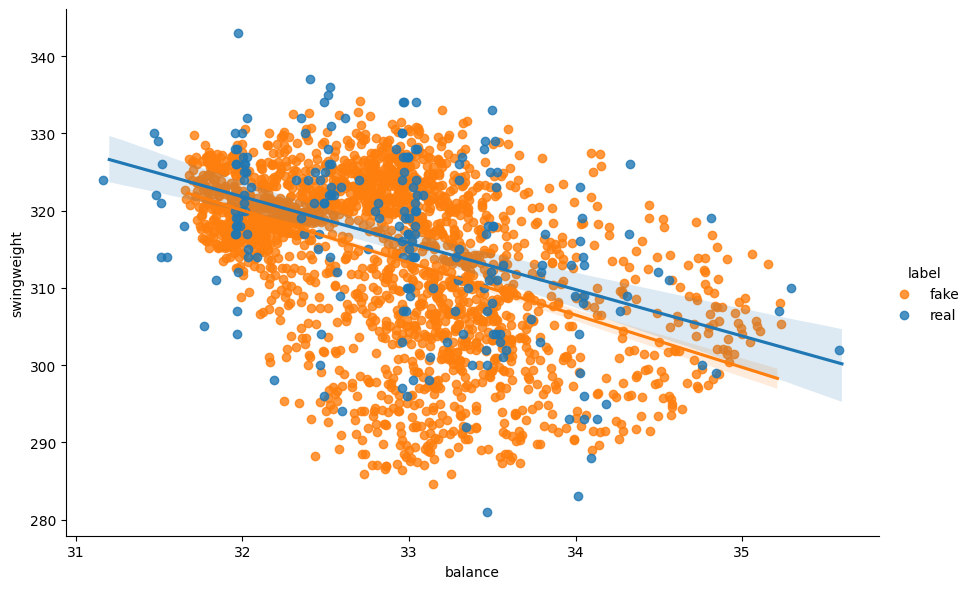

In [ ]:
sns.lmplot(
    x="balance",
    y="swingweight",
    data=comparison_df,
    hue="label",
    x_jitter=0.05,
    palette={"real": "tab:blue", "fake": "tab:orange"},
    height=6,
    aspect=1.5,
)

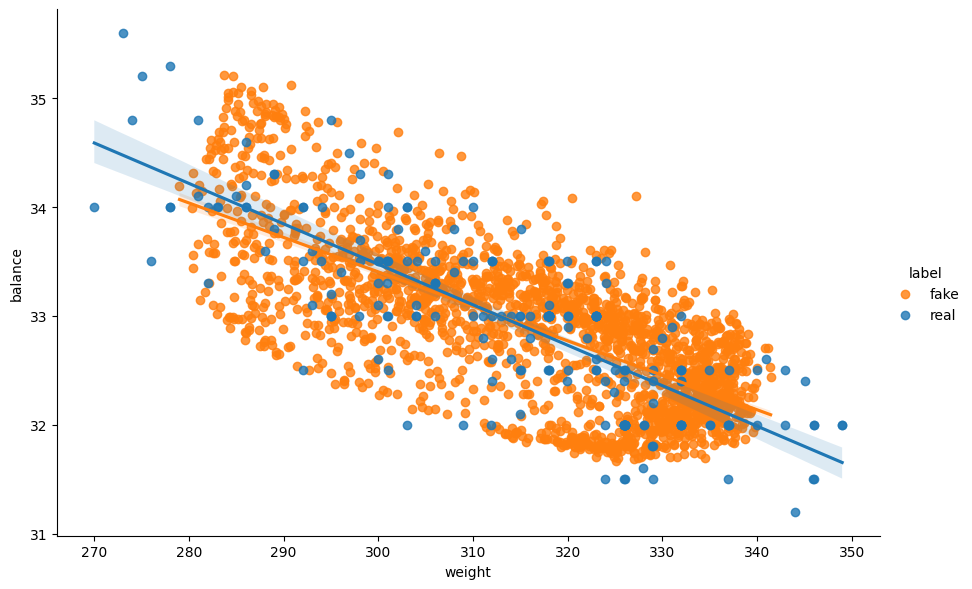

In [ ]:
sns.lmplot(
    x="weight",
    y="balance",
    data=comparison_df,
    hue="label",
    x_jitter=0.05,
    palette={"real": "tab:blue", "fake": "tab:orange"},
    height=6,
    aspect=1.5,
)

In [ ]:
# train base model with normal train data
features = ["weight", "balance"]
label = ["swingweight"]

In [ ]:
X_train = pd.DataFrame(processor.X_train_raw[:, :4], columns=cols[:4])
y_train = processor.X_train_raw[:, 4]

X_train_aug = pd.DataFrame(np.concat([X_train, samples[:, :4]]), columns=cols[:4])
y_train_aug = np.concat([y_train, samples[:, 4]])


X_test = pd.DataFrame(processor.X_val_raw[:, :4], columns=cols[:4])
y_test = processor.X_val_raw[:, 4]

In [ ]:
X_train["feature"] = X_train["weight"] * (X_train["balance"] - 10) ** 2
X_train_aug["feature"] = X_train_aug["weight"] * (X_train_aug["balance"] - 10) ** 2
X_test["feature"] = X_test["weight"] * (X_test["balance"] - 10) ** 2

# round the features
X_train_aug["headsize"] = X_train_aug["headsize"].round()
X_train_aug["weight"] = X_train_aug["weight"].round()
X_train_aug["balance"] = X_train_aug["balance"].round(1)
X_train_aug["flex"] = X_train_aug["flex"].round()
X_train_aug["feature"] = X_train_aug["feature"].round()

X_train_aug

,headsize,weight,balance,flex,feature
0,97.0,346.0,32.000000,65.0,167464.0
1,98.0,332.0,32.000000,68.0,160688.0
2,100.0,318.0,33.000000,67.0,168222.0
3,100.0,324.0,31.500000,67.0,149769.0
4,98.0,323.0,33.000000,66.0,170867.0
...,...,...,...,...,...
2263,100.0,284.0,33.799999,67.0,160628.0
2264,95.0,328.0,32.200001,64.0,161484.0
2265,100.0,300.0,33.200001,70.0,161413.0
2266,100.0,315.0,32.000000,57.0,151837.0


In [ ]:
current_kernel = DotProduct() + WhiteKernel(noise_level=0.8)

matern_kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)

models = [
    LinearRegression(),
    BayesianRidge(),
    tree.DecisionTreeRegressor(max_depth=5),
    ElasticNetCV(
        l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        cv=5,
        random_state=0,
    ),
    GaussianProcessRegressor(kernel=matern_kernel, random_state=42),
    AdaBoostRegressor(n_estimators=30, loss="square"),
    XGBRegressor(random_state=42, n_estimators=50, max_depth=1),
    GradientBoostingRegressor(),
    RandomForestRegressor(),
]

results_all, results_test = evaluate_multiple_models(
    models,
    X_train,
    y_train,
    X_test,
    y_test,
    plot_diagnostics_flag=False,  # Set to True to see plots for each model
    feature_scaler=StandardScaler(),  # Scale features
    target_scaler=StandardScaler(),
)

/Users/niclasmettenleiter/projects/TennisRacketSwingweightPrediction/.hatch/tennisracketswingweightprediction/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.448e-02, tolerance: 1.191e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/niclasmettenleiter/projects/TennisRacketSwingweightPrediction/.hatch/tennisracketswingweightprediction/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.464e-02, tolerance: 1.191e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/niclasmettenleiter/projects/TennisRacketSwingweightPrediction/.hatch/tennisracketswingw

In [ ]:
results_test.sort_values("mae")

,mae,mse,rmse,median_ae,r2,mape,max_error,explained_variance,msle,residual_mean,residual_std,residual_median,residual_mad
BayesianRidge_test,0.387145,0.269177,0.518823,0.309605,0.680875,1.344484,1.680099,0.680886,NaN,-0.003008,0.518814,-0.074862,0.268212
ElasticNetCV_test,0.391365,0.274079,0.523526,0.312166,0.675064,1.358616,1.723027,0.675065,NaN,-0.001194,0.523524,-0.073695,0.269446
LinearRegression_test,0.394635,0.278632,0.527856,0.306590,0.669666,1.366924,1.759075,0.669670,NaN,0.001831,0.527853,-0.063302,0.284069
GaussianProcessRegressor_test,0.397424,0.297192,0.545153,0.327976,0.647662,1.429171,1.858401,0.647667,NaN,0.002205,0.545149,0.022350,0.308366
XGBRegressor_test,0.403006,0.318308,0.564188,0.346058,0.622627,1.458005,1.836108,0.623232,NaN,-0.022590,0.563736,-0.027121,0.318937
RandomForestRegressor_test,0.435679,0.341660,0.584517,0.338282,0.594942,1.556365,1.934441,0.595013,NaN,-0.007764,0.584466,-0.133533,0.315137
GradientBoostingRegressor_test,0.438871,0.369642,0.607982,0.336164,0.561769,1.607207,1.815781,0.565098,NaN,-0.052991,0.605668,-0.156001,0.295311
AdaBoostRegressor_test,0.457209,0.354074,0.595041,0.347343,0.580225,1.396770,1.646901,0.580257,NaN,-0.005139,0.595019,0.028341,0.358655
DecisionTreeRegressor_test,0.549939,0.513926,0.716886,0.456664,0.390712,1.529084,1.958477,0.393599,NaN,-0.049354,0.715185,-0.178771,0.362378


In [ ]:
synthetic_sample_percentages = [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 5, 10]


outputs = {}
for per in synthetic_sample_percentages:
    training_cutoff = len(X_train) + int(len(X_train) * per)

    X_train_aug_ = X_train_aug[:training_cutoff]
    y_train_aug_ = y_train_aug[:training_cutoff]
    results_aug_all, results_aug_test = evaluate_multiple_models(
        models,
        X_train_aug_,
        y_train_aug_,
        X_test,
        y_test,
        plot_diagnostics_flag=False,  # Set to True to see plots for each model
        feature_scaler=StandardScaler(),  # Scale features
        target_scaler=StandardScaler(),
    )
    outputs[str(per)] = results_aug_test["mae"].rename(f"mae_{per}")

/Users/niclasmettenleiter/projects/TennisRacketSwingweightPrediction/.hatch/tennisracketswingweightprediction/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.636e-02, tolerance: 1.422e-02
  model = cd_fast.enet_coordinate_descent_gram(
/Users/niclasmettenleiter/projects/TennisRacketSwingweightPrediction/.hatch/tennisracketswingweightprediction/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.652e-01, tolerance: 1.840e-02
  model = cd_fast.enet_coordinate_descent(
/Users/niclasmettenleiter/projects/TennisRacketSwingweightPrediction/.hatch/tennisracketswingweight

In [ ]:
pd.DataFrame(outputs.values()).T

,mae_0.1,mae_0.25,mae_0.5,mae_0.75,mae_1,mae_1.5,mae_2,mae_5,mae_10
BayesianRidge_test,0.387249,0.393926,0.392097,0.391371,0.391869,0.405737,0.406906,0.432760,0.453754
ElasticNetCV_test,0.392125,0.399221,0.396936,0.393887,0.394013,0.407142,0.407550,0.431893,0.452510
LinearRegression_test,0.395462,0.403181,0.400641,0.397518,0.396498,0.409331,0.409809,0.433707,0.454140
GaussianProcessRegressor_test,0.399710,0.415874,0.420370,0.424098,0.436814,0.453087,0.448703,0.444464,0.474729
XGBRegressor_test,0.415002,0.416167,0.424895,0.444143,0.453084,0.470675,0.486303,0.464582,0.487832
GradientBoostingRegressor_test,0.431712,0.437141,0.411360,0.409639,0.435002,0.464229,0.454616,0.462692,0.473505
RandomForestRegressor_test,0.441048,0.436554,0.438845,0.427970,0.457991,0.445893,0.446152,0.444651,0.451418
DecisionTreeRegressor_test,0.472550,0.484405,0.476234,0.416965,0.410350,0.411477,0.471206,0.474783,0.522890
AdaBoostRegressor_test,0.483445,0.466479,0.477821,0.477064,0.505592,0.524232,0.502010,0.466165,0.534379
